In [348]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import time
from functools import partial
from IPython.display import clear_output
import optax
from tqdm import trange

In [349]:
num_particles = 1
m = 2
hbar = 1
omega = 3

In [350]:
# define a class called Network that represents the neural network
class Old_Network:
    # initialize the network with the number of layers and the number of neurons in each layer
    def __init__(self, num_inputs, neurons):
        self.layers = len(neurons)
        self.neurons = neurons
        self.weights = []
        self.biases = []
        # initialize the weights and biases randomly
        for i in range(self.layers):
            if i == 0:
                self.weights.append(np.random.randn(neurons[i], num_inputs))
                # self.weights.append(np.zeros((neurons[i], num_inputs)))
            else:
                self.weights.append(np.random.randn(neurons[i], neurons[i-1]))
                # self.weights.append(np.zeros((neurons[i], neurons[i-1])))
            self.biases.append(np.random.randn(neurons[i], 1))
            # self.biases.append(np.zeros((neurons[i], 1)))
    # define a function that gets all the weights of the network as a single list
    @partial(jit, static_argnums=(0,))
    def get_weights(self):
        flattened = []
        for i in range(self.layers):
            flattened.append(self.weights[i].flatten())
            flattened.append(self.biases[i].flatten())
        return np.concatenate(flattened)

    # define a function that takes a flattened list of all the weights and biases and returns an unflattened list of weights and biases
    @partial(jit, static_argnums=(0,))
    def unflatten_weights(self, params):
        weights = []
        biases = []
        for i in range(self.layers):
            weight_shape = self.weights[i].shape
            bias_shape = self.biases[i].shape

            weights.append(params[:np.prod(weight_shape)].reshape(weight_shape))
            biases.append(params[np.prod(weight_shape):np.prod(weight_shape)+np.prod(bias_shape)].reshape(bias_shape))
            params = params[np.prod(weight_shape)+np.prod(bias_shape):]
            
        return [weights, biases]

   
   
   # define a function that returns the output of the network given an input of length 1
    @partial(jit, static_argnums=(0,))
    def output(self, x, params):
        c = self.unflatten_weights(params)
        self.weights = c[0]
        self.biases = c[1]
        for i in range(self.layers):
            x = celu(jnp.dot(self.weights[i], x) + self.biases[i])
        return x[0][0]
    


# define a class called Network that represents the neural network
class Network:
    def __init__(self, layers, activation=celu):
        self.layers = layers
        self.activation = activation
        self.params = []
        for i in range(len(layers) - 1):
            self.params.append(np.random.randn(layers[i], layers[i + 1]))
            self.params.append(np.random.randn(layers[i + 1]))
    
    @partial(jit, static_argnums=(0,))
    def output(self, x, params):
        self.params = params
        for i in range(len(self.layers) - 1):
            x = self.activation(jnp.dot(x, self.params[2 * i]) + self.params[2 * i + 1])
        return x
    
    # define a function that flattens the parameters
    # @partial(jit, static_argnums=(0,))
    def flatten_params(self):
        flattened = []
        for i in range(len(self.params)):
            flattened = flattened + self.params[i].flatten().tolist()
        return jnp.array(flattened)
    
    # define a function that unflattens the parameters
    @partial(jit, static_argnums=(0,))
    def unflatten_params(self, flat_params):
        self.params = []
        for i in range(len(self.layers) - 1):
            self.params.append(flat_params[:self.layers[i] * self.layers[i + 1]].reshape(self.layers[i], self.layers[i + 1]))
            flat_params = flat_params[self.layers[i] * self.layers[i + 1]:]
            self.params.append(flat_params[:self.layers[i + 1]])
            flat_params = flat_params[self.layers[i + 1]:]
        return self.params


In [351]:
# initialize the network
nn = Network([1,5,1])

@jit
def psi(coords, params):
    coords = coords.reshape(())
    return jnp.exp(-nn.output(coords, params)) * jnp.exp(-coords**2)


# @jit 
# def psi(coords, params):
#     return jnp.exp(-params[0] * (coords + params[1])**2)

@jit
def sample_body(coords_t, params, key, variation_size):    
    gen_rand = jax.random.uniform(key, minval=-variation_size, maxval=variation_size)
    new_key, subkey = jax.random.split(key)
    
    coords_prime = coords_t + gen_rand
    temp_rand = jax.random.uniform(subkey, minval=0, maxval=1)
    return (jax.lax.cond(temp_rand < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key)

def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=5, key=jax.random.PRNGKey(np.random.randint(0,100)), skipping = True):
    outputs = []
    all_data = []

    coords_t = np.random.uniform(-variation_size, variation_size)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_t, key = sample_body(coords_t, params, key, variation_size)
        if ((step > thermalization_steps) & (step % skip_count == 0) & (skipping == True)):
            outputs.append(coords_t)
        elif skipping == False:
            all_data.append(coords_t)
    if skipping == False:
        return all_data
    return jnp.array(outputs)


# sample_body function except it also returns whether or not the move was accepted
@jit
def sample_body_accept(coords_t, params, key,variation_size):
    gen_rand = jax.random.uniform(key, minval=-variation_size, maxval=variation_size)
    new_key, subkey = jax.random.split(key)
    
    coords_prime = coords_t + gen_rand
    condition = jax.random.uniform(subkey, minval=0, maxval=1) < psi(coords_prime, params)**2/psi(coords_t, params)**2
    return (jax.lax.cond(condition, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key, condition)


# the sample function without any thermalization steps or skipping steps
def accept_ratio(params, num_samples=10**3, variation_size=5.0, key=jax.random.PRNGKey(np.random.randint(0,100))):
    coords_t = np.random.uniform(-variation_size, variation_size)
    num_accepted = 0
    for _ in range(num_samples):
        coords_t, key, accepted = sample_body_accept(coords_t, params, key, variation_size)
        if accepted:
            num_accepted += 1

    return num_accepted / num_samples



# second derivative of the wavefunction with respect to the coordinate
ddpsi = jit(grad(jit(grad(psi, 0, allow_int = True)), 0, allow_int = True))

@jit
def Hpsi(coords, params):
    return (m*.5*omega**2*coords**2) - hbar**2 / (2*m) * ddpsi(coords, params) * 1/psi(coords, params)

venergy = jit(vmap(Hpsi, in_axes=(0, None), out_axes=0))

@jit
def logpsi(coords, params):
    return jnp.log(psi(coords, params))

# define the derivative with respect to every parameter of the log of psi:
dlogpsi_dtheta_stored = jit(grad(logpsi, 1))

vlog_term = jit(vmap(dlogpsi_dtheta_stored, in_axes=(0, None), out_axes=0))

vboth = vmap(jnp.multiply, in_axes=(0, 0), out_axes=0)

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=5, verbose=False):
    # get the samples
    samples = sample(params, num_samples, thermal, skip, variation_size)
    psiHpsi = venergy(samples, params)
    logs = vlog_term(samples, params)
    
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples)

    energy = 1/num_samples * jnp.sum(psiHpsi)
    if verbose:
        print(energy)
    log_term = 1/num_samples * jnp.sum(logs,0)

    both = 1/num_samples * jnp.sum(vboth(psiHpsi, logs),0)

    gradient_calc = (2 * both - 2 * energy * log_term)
    return gradient_calc, energy, uncert


In [352]:
# define a function that takes in samples, bins them, and returns the average of each bin
def bin_samples(energies, bin_size):
    # first, bin the samples
    binned = np.array_split(energies, bin_size)
    # now, calculate the average of each bin
    binned_averages = [np.mean(b) for b in binned]
    # now, calculate the uncertainty of each bin
    bin_uncerts = np.std(binned_averages)/np.sqrt(bin_size)
    return bin_uncerts


# define a function that gets all samples, and then bins them with different bin sizes
def autocorrelation(params):
    samples = sample(params, num_samples=10**3, thermalization_steps=200, skip_count=40, variation_size=1, key=jax.random.PRNGKey(np.random.randint(0,100)), skipping = False)
    energies = [Hpsi(s, params) for s in samples]
    
    bins = np.linspace(1, 100, 100, dtype=int)
    # now plot the average energy as a function of the number of bins
    us = []
    for b_size in bins:
        us.append(bin_samples(energies, b_size))
    plt.scatter(bins, us)
    plt.title("Bin size vs. Uncertainty")
    plt.xlabel("Bin size")
    plt.ylabel("Uncertainty")
    plt.show()


In [353]:
def train(params, iterations, N, thermal, skip, variation_size, optimizer):
    hs = []
    us = []
    opt_state = optimizer.init(params)
    
    def step(params, opt_state, N, thermal, skip, variation_size):
        gr = gradient(params, N, thermal, skip, variation_size)
        # print(gr)
        hs.append(gr[1])
        us.append(gr[2])
        updates, opt_state = optimizer.update(gr[0], opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, gr[1]

    pbar = trange(iterations, desc="", leave=True)
    for step_num in pbar:   
        params, opt_state, energy = step(params, opt_state, N, thermal, skip, variation_size)
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, params

In [354]:
print(nn.params)
print(nn.output(np.array([1]).reshape(1,1), nn.params))

[array([[-0.44142202, -0.79057516,  0.55734385, -0.47914602, -0.50805627]]), array([-1.27694732, -0.16477716,  1.30187937,  1.95135603,  0.25329497]), array([[ 1.6431674 ],
       [-0.25189165],
       [ 0.14341291],
       [ 0.705454  ],
       [-1.1571718 ]]), array([-0.78847879])]
[[-0.3406338]]


In [355]:
print(nn.flatten_params())

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[1,5] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was output at /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/1287397952.py:67 traced for jit.
------------------------------
The leaked intermediate value was created on line /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3170712139.py:2 (<module>). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/async_helpers.py:129 (_pseudo_sync_runner)
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3194 (run_cell_async)
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3373 (run_ast_nodes)
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3433 (run_code)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3170712139.py:2 (<module>)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [ ]:
autocorrelation(nn.flatten_params())

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[1,5] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was output at /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/568208017.py:11 traced for jit.
------------------------------
The leaked intermediate value was created on line /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3170712139.py:2 (<module>). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/async_helpers.py:129 (_pseudo_sync_runner)
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3194 (run_cell_async)
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3373 (run_ast_nodes)
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3433 (run_code)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3170712139.py:2 (<module>)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [ ]:
variation = 1.2
print("Accept/Reject ratio",accept_ratio(nn.flatten_params(), num_samples=10**4, variation_size=variation))

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[16] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was psi at /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3067798161.py:4 traced for xla_call.
------------------------------
The leaked intermediate value was created on line /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3067798161.py:68 (Hpsi). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3433 (run_code)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/1320714403.py:1 (<module>)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3156548606.py:15 (autocorrelation)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3156548606.py:15 (<listcomp>)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3067798161.py:68 (Hpsi)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

In [ ]:
total_hists = []
total_uncerts = []
params = nn.flatten_params()

hists, uncerts, params = train(params, 50, 10**3, 200, 40, variation, optax.adam(0.1))
total_hists = total_hists + list(hists)
total_uncerts = total_uncerts + list(uncerts) 

UnexpectedTracerError: Encountered an unexpected tracer. A function transformed by JAX had a side effect, allowing for a reference to an intermediate value with type float32[16] wrapped in a DynamicJaxprTracer to escape the scope of the transformation.
JAX transformations require that functions explicitly return their outputs, and disallow saving intermediate values to global state.
The function being traced when the value leaked was psi at /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3067798161.py:4 traced for xla_call.
------------------------------
The leaked intermediate value was created on line /var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3067798161.py:68 (Hpsi). 
------------------------------
When the value was created, the final 5 stack frames (most recent last) excluding JAX-internal frames were:
------------------------------
/Users/hersh/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3433 (run_code)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/1320714403.py:1 (<module>)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3156548606.py:15 (autocorrelation)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3156548606.py:15 (<listcomp>)
/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/ipykernel_25735/3067798161.py:68 (Hpsi)
------------------------------

To catch the leak earlier, try setting the environment variable JAX_CHECK_TRACER_LEAKS or using the `jax.checking_leaks` context manager.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.UnexpectedTracerError

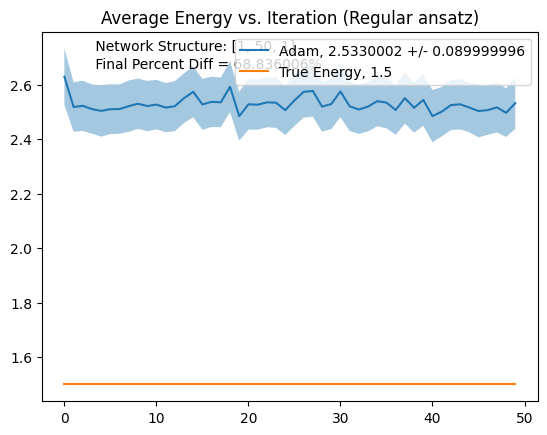

In [ ]:

true_energy = .5 * hbar * omega
plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam, " + str(round(total_hists[-1],3)) + " +/- " + str(round(total_uncerts[-1], 2)))
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
# structure = nn.neurons
# plt.annotate(" Network Structure: " + str(structure), xy=(0.1, 0.95), xycoords='axes fraction')
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (total_hists[-1] - true_energy)/true_energy*100
plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
plt.title("Average Energy vs. Iteration (Regular ansatz)")
plt.show()